# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Advanced Lane Finding Project

In this notebook, functionality is implemented in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, Python code is successfully imported and included in this submission. 

### The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### Import required Libraries.

In [1]:
import numpy as np
import glob
import cv2
import pickle
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Camera Calibration using Chessboard Images.
#### Chessboard Corner Detection in Images

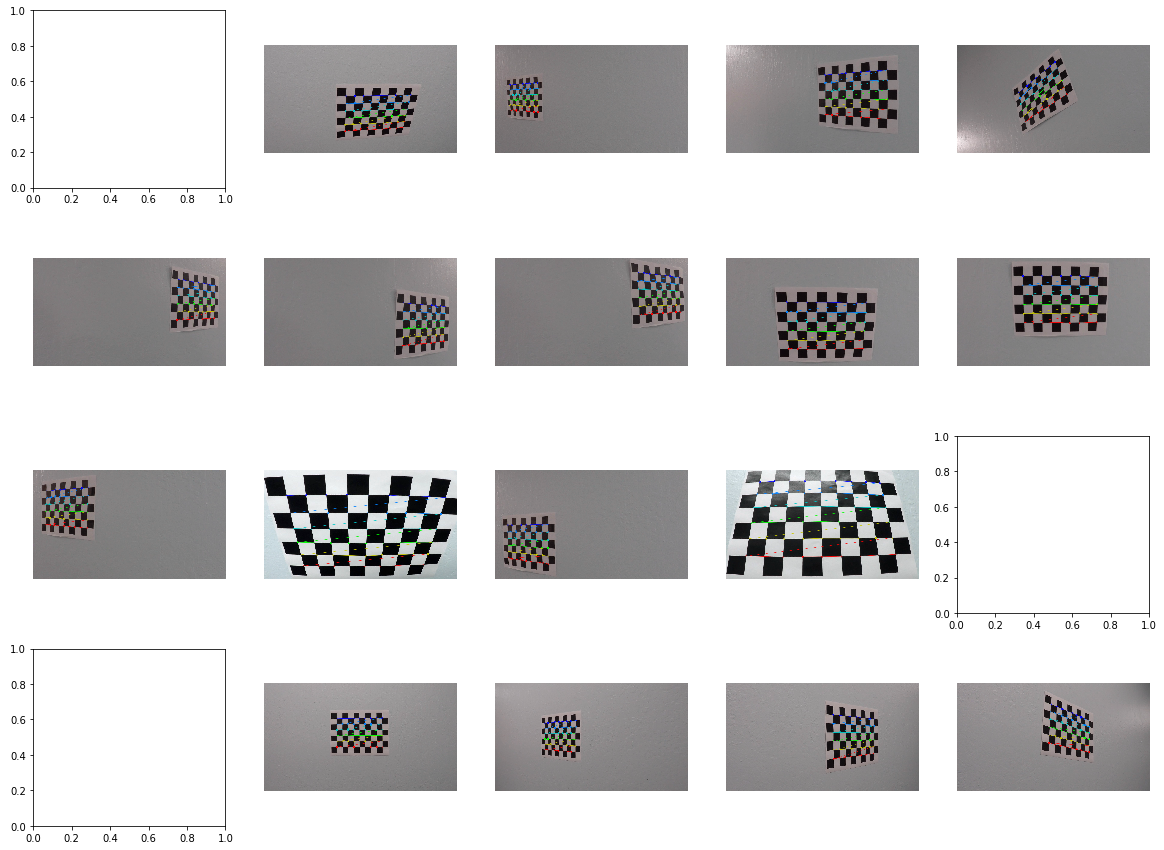

In [2]:
# Array to store Object Points and Image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image space
nx = 9
ny = 6
#img_shape = None

# Load the Images using glob function.
images = glob.glob('./camera_cal/calibration*.jpg')

# create object points started with numpy zeros and using numpy mgrid functions.
# Points will be like (0,0,0) (1,0,0) (2,0,0) ...... (8,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y co-ordinates.

# Plot the images
fig, vaxis = plt.subplots(4, 5, figsize=(20, 15))
vaxis = vaxis.ravel()

# Ierate through the set of images given.
for i, fname in enumerate(images):
    # read the image and convert to grayscale using cvtColor function.
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners in the grayscale image.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners detected, add object points and image points.
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw chessboard cornors on all images and display them.
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #img_shape = gray
        vaxis[i].axis('off')
        vaxis[i].imshow(img)

#### Calibration of Images

Calibration Done.


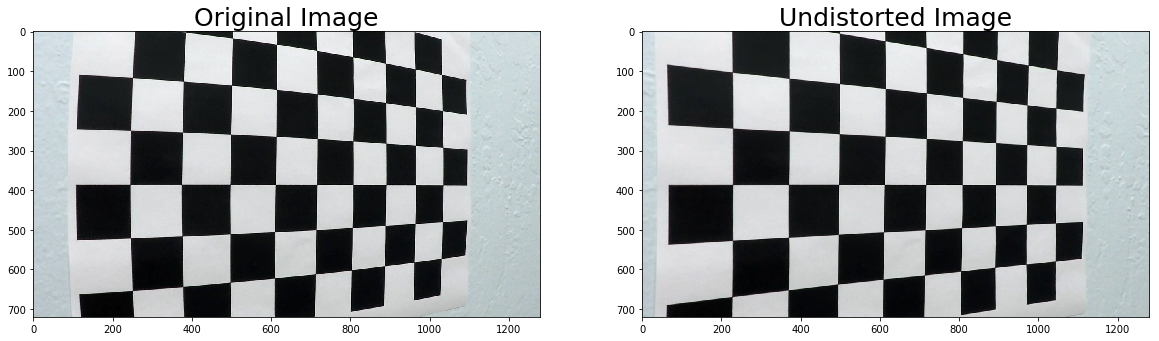

In [3]:
img = cv2.imread('./camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
print('Calibration Done.')

# Visualize undistortion
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img)
vaxis1.set_title('Original Image', fontsize=25)
vaxis2.imshow(dst)
vaxis2.set_title('Undistorted Image', fontsize=25)
plt.show()

### Complete Pipeline
#### Select Test Image for Pipeline and display.

Selected Image.


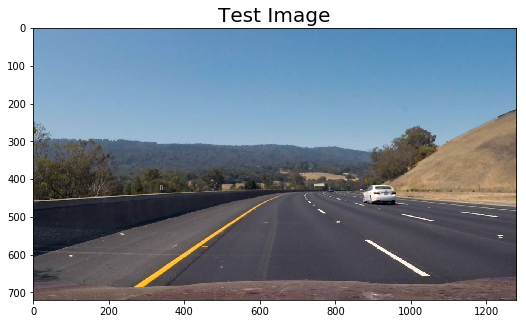

In [4]:
# Choose an image from which to build and demonstrate each step of the pipeline
img_test = cv2.imread('./test_images/test3.jpg')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
fig, vaxis = plt.subplots(1, 1, figsize=(10,5))
vaxis.imshow(img_test)
vaxis.set_title('Test Image', fontsize=20)
print('Selected Image.')

#### Undistort Image

Undistorted Image Done.


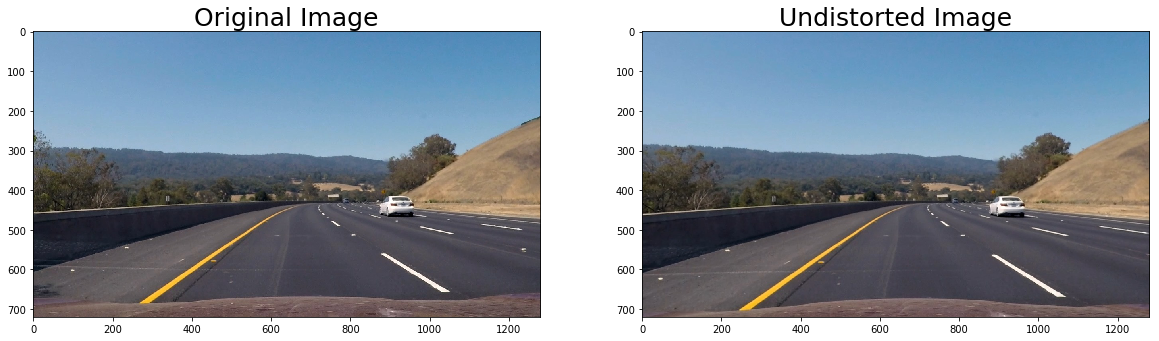

In [5]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

print('Undistorted Image Done.')

# Visualize Undistorted Image.
img_undist = undistort(img_test)
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_test)
vaxis1.set_title('Original Image', fontsize=25)
vaxis2.imshow(img_undist)
vaxis2.set_title('Undistorted Image', fontsize=25)
plt.show()

#### Perspective Transform

Unwarp Image Done.


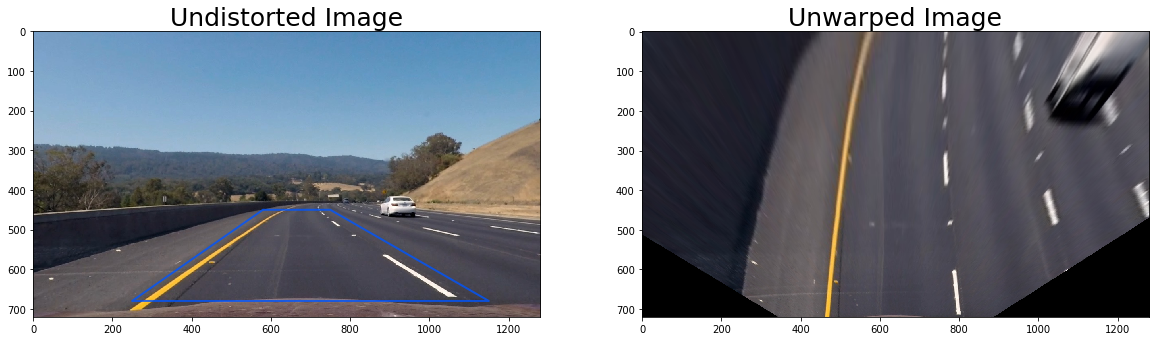

In [6]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M & Minv, the transform matrix and inverse matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp the image to birds view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

print('Unwarp Image Done.')

# Visualize Perspective Transform
h,w = img_undist.shape[:2]
# define source and destination points for transform
#src = np.float32([(575,464), (707,464), (258,682), (1049,682)])
#dst = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])
src = np.float32([(580,450), (750,450), (250,680), (1150,680)])
dst = np.float32([(450,0), (w-450,0), (450,h), (w-450,h)])

img_unwarp, M, Minv = unwarp(img_undist, src, dst)

# Visualize unwarp
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_undist)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
vaxis1.plot(x, y, color='#0055ff', alpha=0.8, linewidth=2, solid_capstyle='round', zorder=2)
vaxis1.set_ylim([h,0])
vaxis1.set_xlim([0,w])
vaxis1.set_title('Undistorted Image', fontsize=25)
vaxis2.imshow(img_unwarp)
vaxis2.set_title('Unwarped Image', fontsize=25)
plt.show()

#### Sobel Absolute Threshold

Sobel Absolute Threshold Applied.


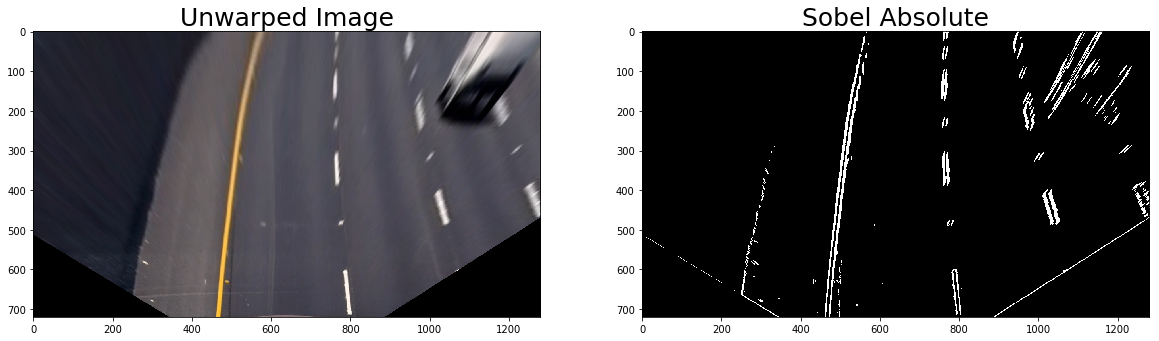

In [7]:
# Function that applies Sobel x or y, 
# takes an absolute value and applies a threshold.
def sobel_abs(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output
print('Sobel Absolute Threshold Applied.')

# Visualize Sobel Absolute Threshold
img_sobelAbs = sobel_abs(img_unwarp, 'x', 25, 255)
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_unwarp)
vaxis1.set_title('Unwarped Image', fontsize=25)
vaxis2.imshow(img_sobelAbs, cmap='gray')
vaxis2.set_title('Sobel Absolute', fontsize=25)
plt.show()

#### Sobel Magnitude Threshold

Sobel Magnitude Threshold Applied.


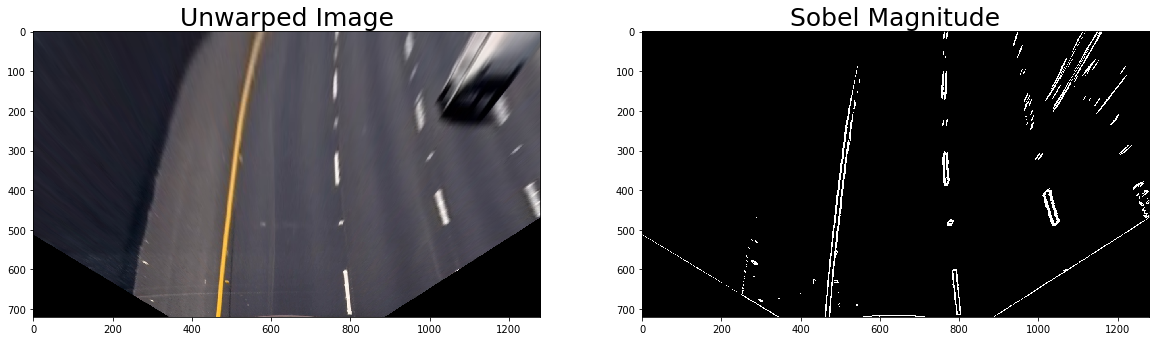

In [8]:
# Function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def sobel_mag(img, sobel_kernel=25, mag_thresh=(25, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output
print('Sobel Magnitude Threshold Applied.')

# Visualize Sobel Magnitude Threshold
img_sobelMag = sobel_mag(img_unwarp, 25, (25, 255))
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_unwarp)
vaxis1.set_title('Unwarped Image', fontsize=25)
vaxis2.imshow(img_sobelMag, cmap='gray')
vaxis2.set_title('Sobel Magnitude', fontsize=25)
plt.show()

#### Sobel Direction Threshold

Sobel Direction Threshold Applied.


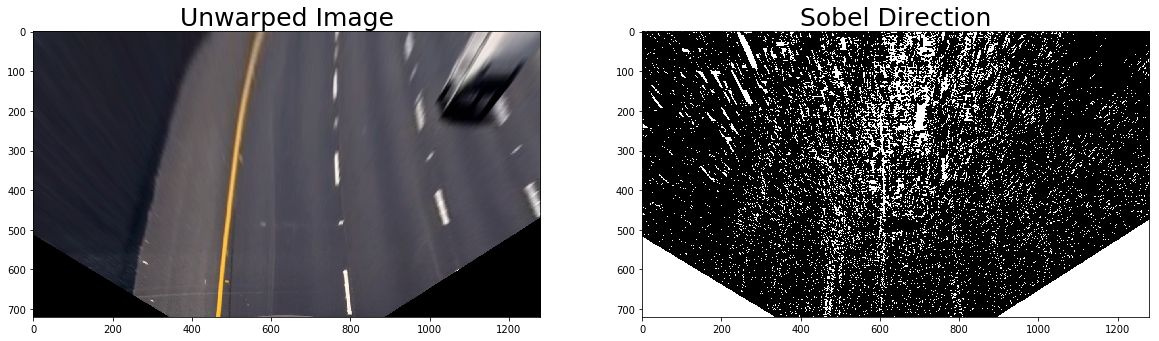

In [9]:
# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def sobel_dir(img, sobel_kernel=7, thresh=(0, 0.09)):    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output
print('Sobel Direction Threshold Applied.')

# Visualize Sobel Direction Threshold
img_sobelDir = sobel_dir(img_unwarp, 7, (0, 0.09))
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_unwarp)
vaxis1.set_title('Unwarped Image', fontsize=25)
vaxis2.imshow(img_sobelDir, cmap='gray')
vaxis2.set_title('Sobel Direction', fontsize=25)
plt.show()

#### Sobel Magnitude + Direction Threshold

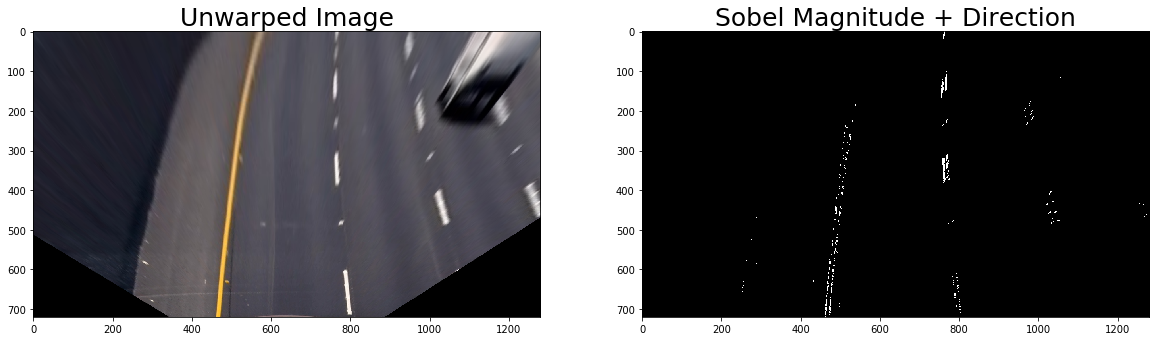

In [10]:
img_sobelMag2 = sobel_mag(img_unwarp, 25, (25, 255))
img_sobelDir2 = sobel_dir(img_unwarp, 7, (0, 0.09))
combined = np.zeros_like(img_sobelMag2)
combined[((img_sobelMag2 == 1) & (img_sobelDir2 == 1))] = 1

# Visualize sobel magnitude + direction threshold
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_unwarp)
vaxis1.set_title('Unwarped Image', fontsize=25)
vaxis2.imshow(combined, cmap='gray')
vaxis2.set_title('Sobel Magnitude + Direction', fontsize=25)
plt.show()

#### Visualization of Colorspace Channels

Visualization of Colorspace Channels Done.


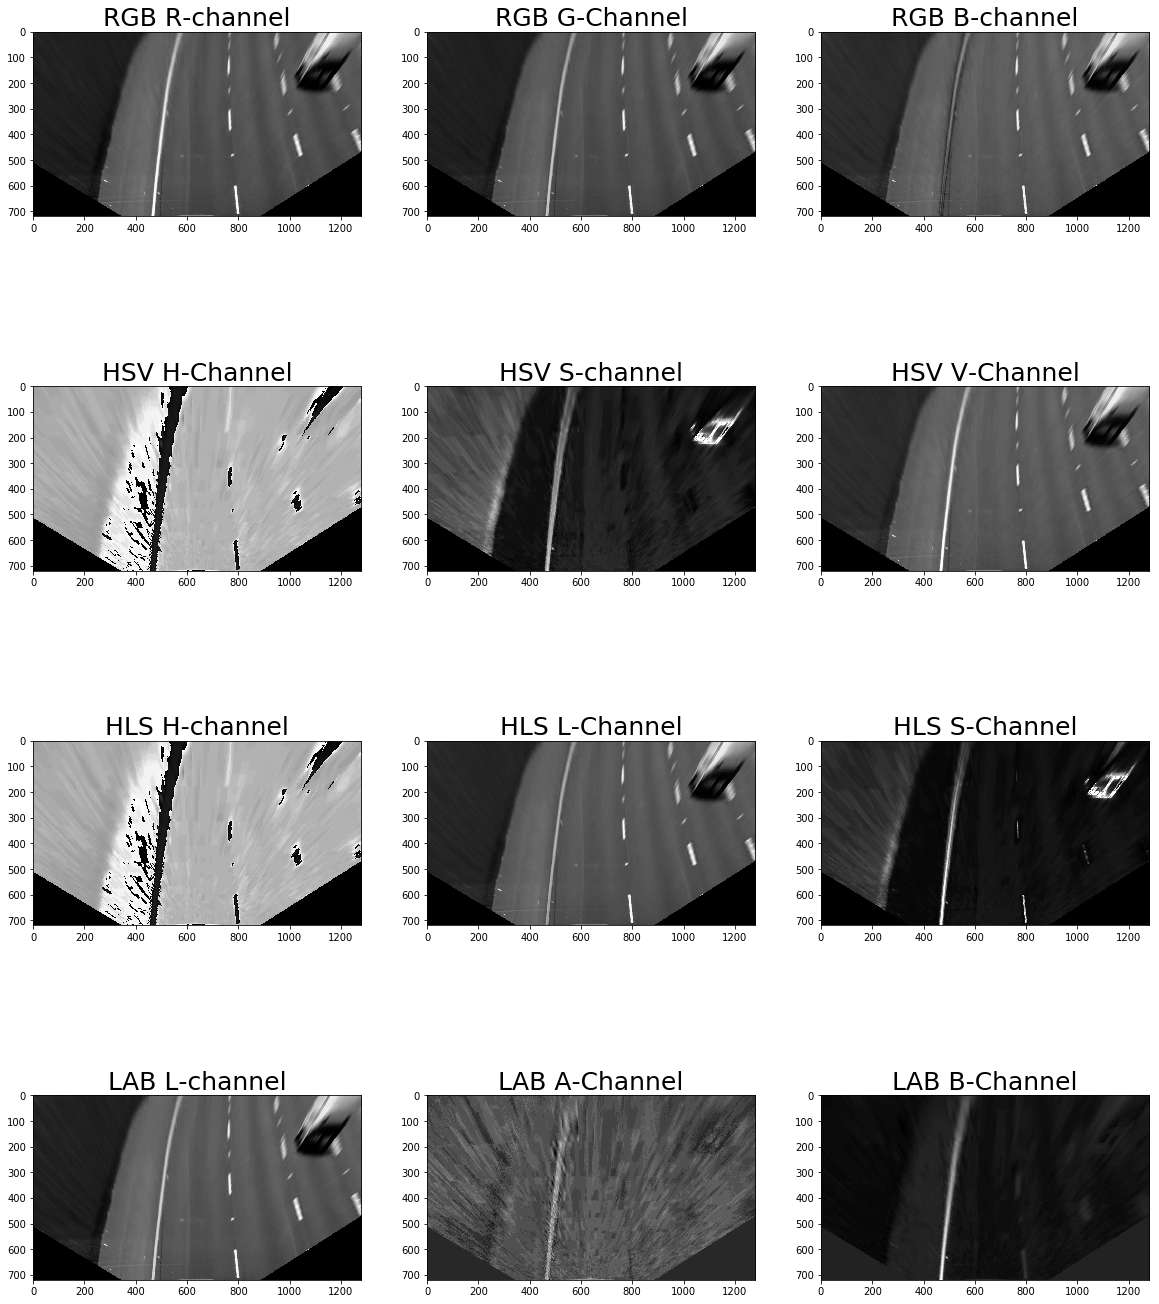

In [11]:
# Visualize multiple color space channels
img_unwarp_R = img_unwarp[:,:,0]
img_unwarp_G = img_unwarp[:,:,1]
img_unwarp_B = img_unwarp[:,:,2]
img_unwarp_HSV = cv2.cvtColor(img_unwarp, cv2.COLOR_RGB2HSV)
img_unwarp_H = img_unwarp_HSV[:,:,0]
img_unwarp_S = img_unwarp_HSV[:,:,1]
img_unwarp_V = img_unwarp_HSV[:,:,2]
img_unwarp_HLS = cv2.cvtColor(img_unwarp, cv2.COLOR_RGB2HLS)
img_unwarp_H2 = img_unwarp_HLS[:,:,0]
img_unwarp_L = img_unwarp_HLS[:,:,1]
img_unwarp_S2 = img_unwarp_HLS[:,:,2]
img_unwarp_LAB = cv2.cvtColor(img_unwarp, cv2.COLOR_RGB2Lab)
img_unwarp_L2 = img_unwarp_LAB[:,:,0]
img_unwarp_A = img_unwarp_LAB[:,:,1]
img_unwarp_B2 = img_unwarp_LAB[:,:,2]

# Plotting all Colorspace channel Images.
fig, vaxis = plt.subplots(4,3, figsize=(20, 25))
vaxis = vaxis.ravel()
vaxis[0].imshow(img_unwarp_R, cmap='gray')
vaxis[0].set_title('RGB R-channel', fontsize=25)
vaxis[1].imshow(img_unwarp_G, cmap='gray')
vaxis[1].set_title('RGB G-Channel', fontsize=25)
vaxis[2].imshow(img_unwarp_B, cmap='gray')
vaxis[2].set_title('RGB B-channel', fontsize=25)
vaxis[3].imshow(img_unwarp_H, cmap='gray')
vaxis[3].set_title('HSV H-Channel', fontsize=25)
vaxis[4].imshow(img_unwarp_S, cmap='gray')
vaxis[4].set_title('HSV S-channel', fontsize=25)
vaxis[5].imshow(img_unwarp_V, cmap='gray')
vaxis[5].set_title('HSV V-Channel', fontsize=25)
vaxis[6].imshow(img_unwarp_H2, cmap='gray')
vaxis[6].set_title('HLS H-channel', fontsize=25)
vaxis[7].imshow(img_unwarp_L, cmap='gray')
vaxis[7].set_title('HLS L-Channel', fontsize=25)
vaxis[8].imshow(img_unwarp_S2, cmap='gray')
vaxis[8].set_title('HLS S-Channel', fontsize=25)
vaxis[9].imshow(img_unwarp_L2, cmap='gray')
vaxis[9].set_title('LAB L-channel', fontsize=25)
vaxis[10].imshow(img_unwarp_A, cmap='gray')
vaxis[10].set_title('LAB A-Channel', fontsize=25)
vaxis[11].imshow(img_unwarp_B2, cmap='gray')
vaxis[11].set_title('LAB B-Channel', fontsize=25)
print('Visualization of Colorspace Channels Done.')

#### HLS L-Channel

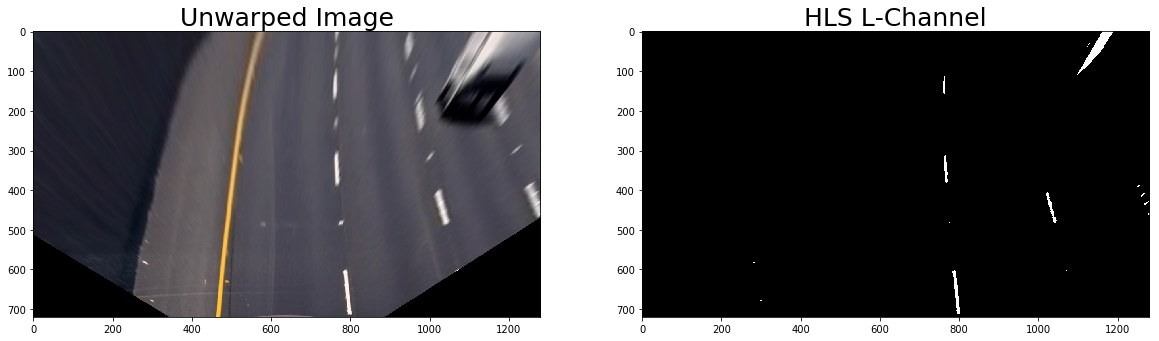

In [12]:
# Function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=), (B channel should capture whites)
def hls_l_color(img, thresh=(220, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary_output

# Visualize L Channel threshold
img_L_color = hls_l_color(img_unwarp, (220, 255))
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_unwarp)
vaxis1.set_title('Unwarped Image', fontsize=25)
vaxis2.imshow(img_L_color, cmap='gray')
vaxis2.set_title('HLS L-Channel', fontsize=25)
plt.show()

#### LAB B-Channel

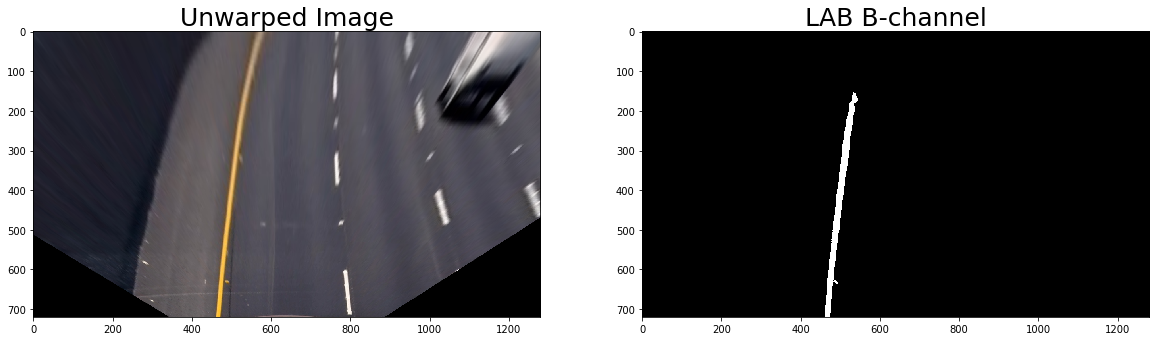

In [13]:
# Function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_b_color(img, thresh=(190,255)):
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # Return a binary image of threshold result
    return binary_output

# Visualize LAB Channel Threshold
img_B_color = lab_b_color(img_unwarp, (190, 255))
fig, (vaxis1, vaxis2) = plt.subplots(1, 2, figsize=(20,10))
vaxis1.imshow(img_unwarp)
vaxis1.set_title('Unwarped Image', fontsize=25)
vaxis2.imshow(img_B_color, cmap='gray')
vaxis2.set_title('LAB B-channel', fontsize=25)
plt.show()

#### Define Image Processing Pipeline

In [14]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
def run_pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # HLS L-channel Threshold (using default parameters)
    img_L = hls_l_color(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_B = lab_b_color(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_B)
    combined[(img_L == 1) | (img_B == 1)] = 1
    return combined, Minv

#### Run Pipeline on All Test Images

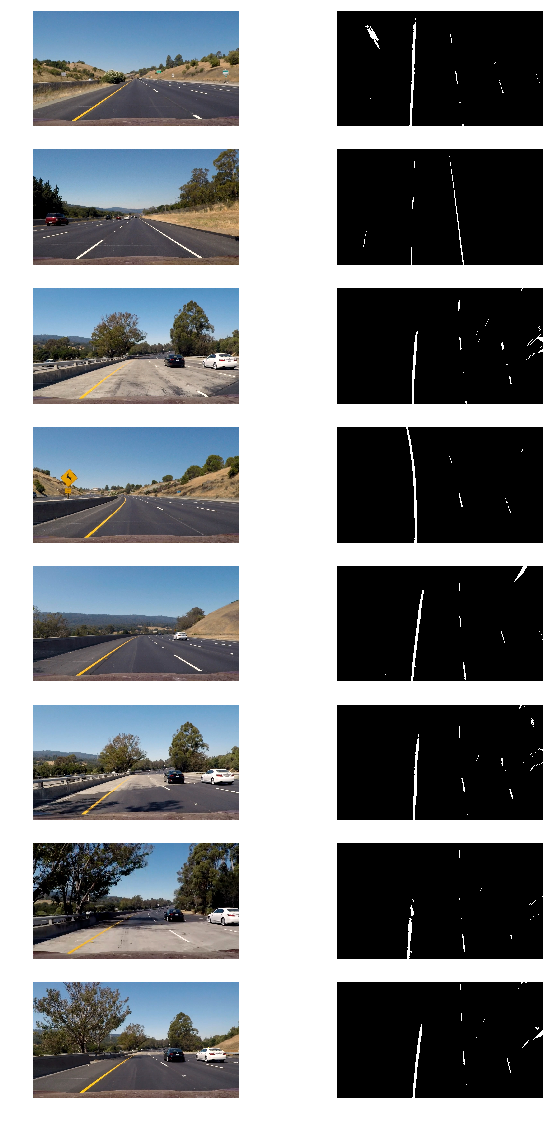

In [15]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, vaxis = plt.subplots(len(images),2, figsize=(10, 20))
vaxis = vaxis.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = run_pipeline(img)
    vaxis[i].imshow(img)
    vaxis[i].axis('off')
    i += 1
    vaxis[i].imshow(img_bin, cmap='gray')
    vaxis[i].axis('off')
    i += 1


#### Sliding Window Polyfit

(720, 0)

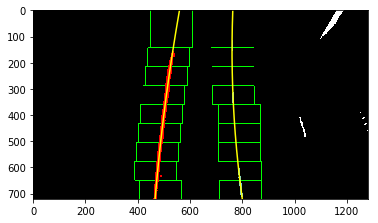

In [16]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Number of sliding windows
    nwindows = 10
    # Height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lindx = []
    right_lindx = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_yl = img.shape[0] - (window+1)*window_height
        win_yh = img.shape[0] - window*window_height
        win_xll = leftx_current - margin
        win_xlh = leftx_current + margin
        win_xrl = rightx_current - margin
        win_xrh = rightx_current + margin
        rectangle_data.append((win_yl, win_yh, win_xll, win_xlh, win_xrl, win_xrh))
        # Identify the nonzero pixels in x and y within the window
        left_indx = ((nonzeroy >= win_yl) & (nonzeroy < win_yh) & (nonzerox >= win_xll) & (nonzerox < win_xlh)).nonzero()[0]
        right_indx = ((nonzeroy >= win_yl) & (nonzeroy < win_yh) & (nonzerox >= win_xrl) & (nonzerox < win_xrh)).nonzero()[0]
        # Append these indices to the lists
        left_lindx.append(left_indx)
        right_lindx.append(right_indx)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_indx) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_indx]))
        if len(right_indx) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_indx]))

    # Concatenate the arrays of indices
    left_lindx = np.concatenate(left_lindx)
    right_lindx = np.concatenate(right_lindx)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lindx]
    lefty = nonzeroy[left_lindx] 
    rightx = nonzerox[right_lindx]
    righty = nonzeroy[right_lindx] 

    lfit, rfit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        lfit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        rfit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return lfit, rfit, left_lindx, right_lindx, visualization_data

# visualize the result on example image
img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_bin, Minv = run_pipeline(img)
    
lfit, rfit, left_lindx, right_lindx, visualization_data = sliding_window_polyfit(img_bin)

h = img.shape[0]
lfit_x = lfit[0]*h**2 + lfit[1]*h + lfit[2]
rfit_x = rfit[0]*h**2 + rfit[1]*h + rfit[2]
rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((img_bin, img_bin, img_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
lfitx = lfit[0]*ploty**2 + lfit[1]*ploty + lfit[2]
rfitx = rfit[0]*ploty**2 + rfit[1]*ploty + rfit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lindx], nonzerox[left_lindx]] = [255, 0, 0]
out_img[nonzeroy[right_lindx], nonzerox[right_lindx]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(lfitx, ploty, color='yellow')
plt.plot(rfitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(0, 1280)

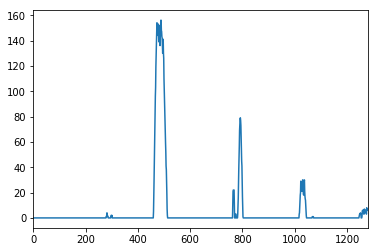

In [17]:
# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0, 1280)

#### Polyfit Using Fit from Previous Frame

(720, 0)

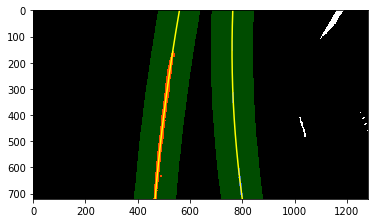

In [18]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def prev_polyfit(binary_img, lfit_prev, rfit_prev):
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lindx = ((nonzerox > (lfit_prev[0]*(nonzeroy**2) + lfit_prev[1]*nonzeroy + lfit_prev[2] - margin)) & 
                      (nonzerox < (lfit_prev[0]*(nonzeroy**2) + lfit_prev[1]*nonzeroy + lfit_prev[2] + margin))) 
    right_lindx = ((nonzerox > (rfit_prev[0]*(nonzeroy**2) + rfit_prev[1]*nonzeroy + rfit_prev[2] - margin)) & 
                       (nonzerox < (rfit_prev[0]*(nonzeroy**2) + rfit_prev[1]*nonzeroy + rfit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lindx]
    lefty = nonzeroy[left_lindx] 
    rightx = nonzerox[right_lindx]
    righty = nonzeroy[right_lindx]
    
    lfit_new, rfit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        lfit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        rfit_new = np.polyfit(righty, rightx, 2)
    return lfit_new, rfit_new, left_lindx, right_lindx

# visualize the result on example image
img2 = cv2.imread('./test_images/test3.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_bin, Minv = run_pipeline(img2)   
margin = 80

lfit2, rfit2, left_lindx2, right_lindx2 = prev_polyfit(img2_bin, lfit, rfit)

# Generate x and y values for plotting
ploty = np.linspace(0, img2_bin.shape[0]-1, img2_bin.shape[0] )
lfitx = lfit[0]*ploty**2 + lfit[1]*ploty + lfit[2]
rfitx = rfit[0]*ploty**2 + rfit[1]*ploty + rfit[2]
lfitx2 = lfit2[0]*ploty**2 + lfit2[1]*ploty + lfit2[2]
rfitx2 = rfit2[0]*ploty**2 + rfit2[1]*ploty + rfit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((img2_bin, img2_bin, img2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = img2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lindx2], nonzerox[left_lindx2]] = [255, 0, 0]
out_img[nonzeroy[right_lindx2], nonzerox[right_lindx2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_window1 = np.array([np.transpose(np.vstack([lfitx-margin, ploty]))])
left_window2 = np.array([np.flipud(np.transpose(np.vstack([lfitx+margin, ploty])))])
left_pts = np.hstack((left_window1, left_window2))
right_window1 = np.array([np.transpose(np.vstack([rfitx-margin, ploty]))])
right_window2 = np.array([np.flipud(np.transpose(np.vstack([rfitx+margin, ploty])))])
right_pts = np.hstack((right_window1, right_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(lfitx2, ploty, color='yellow')
plt.plot(rfitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### Radius of Curvature and Distance from Lane Center Calculation

In [19]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_rad_dist(bin_img, l_fit, r_fit, l_lindx, r_lindx):
    # Define conversions in x and y from pixels space to meters
    y_metppix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    x_metppix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    lcurve, rcurve, cdist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lindx]
    lefty = nonzeroy[l_lindx] 
    rightx = nonzerox[r_lindx]
    righty = nonzeroy[r_lindx]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        lfit_cr = np.polyfit(lefty*y_metppix, leftx*x_metppix, 2)
        rfit_cr = np.polyfit(righty*y_metppix, rightx*x_metppix, 2)
        # Calculate the new radii of curvature
        lcurve = ((1 + (2*lfit_cr[0]*y_eval*y_metppix + lfit_cr[1])**2)**1.5) / np.absolute(2*lfit_cr[0])
        rcurve = ((1 + (2*rfit_cr[0]*y_eval*y_metppix + rfit_cr[1])**2)**1.5) / np.absolute(2*rfit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        cdist = (car_position - lane_center_position) * x_metppix
    return lcurve, rcurve, cdist

rad_l, rad_r, d_center = calc_rad_dist(img_bin, lfit, rfit, left_lindx, right_lindx)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 757.593596478 m, 390.720756504 m
Distance from lane center for example: 0.0670508915848 m


#### Draw the Detected Lane Back onto the Original Image

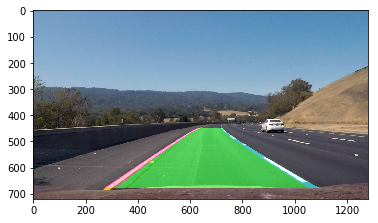

In [20]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    lfitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    rfitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([lfitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rfitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

img_out1 = draw_lane(img, img_bin, lfit, rfit, Minv)
plt.imshow(img_out1)
plt.show()

#### Draw Curvature Radius and Distance from Center Data onto the Original Image

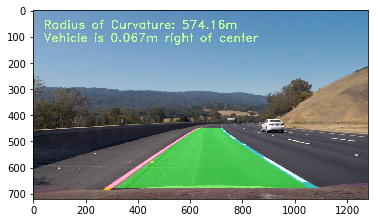

In [21]:
def draw_rad_dist(original_img, curve, cdist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(curve) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if cdist > 0:
        direction = 'right'
    elif cdist < 0:
        direction = 'left'
    abs_cdist = abs(cdist)
    text = 'Vehicle is ' + '{:04.3f}'.format(abs_cdist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

img_out2 = draw_rad_dist(img_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(img_out2)
plt.show()

#### Define a Line class for storing Data

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        #self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        #self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        #self.radius = None 
        #distance in meters of vehicle center from the line
        #self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

#### Process Image Pipeline

In [23]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = run_pipeline(new_img)
    
    # if both left and right lines were detected last frame, use prev_polyfit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lindx, r_lindx, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lindx, r_lindx = prev_polyfit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lindx)
    r_line.add_fit(r_fit, r_lindx)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_rad_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lindx, r_lindx)
        img_out = draw_rad_dist(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    return img_out

#### Process Project Video's

In [24]:
def process_video(inp_vid, out_vid):
    input_vid = VideoFileClip(inp_vid)
    output_vid = input_vid.fl_image(process_image)
    output_vid.write_videofile(out_vid, audio=False)
    print('Output Files Write Complete.')

#### Run Process Video's and save the video's locally

In [25]:
# Main Function consisting of complete lane detection pipeline.

# Input and output video lists which contains names for reference.
video_input = ['project_video.mp4',  'challenge_video.mp4', 'harder_challenge_video.mp4']
video_output = ['project_video_out.mp4',  'challenge_video_out.mp4', 'harder_challenge_video_out.mp4']
l_line = Line()
r_line = Line()

# Writing Output Video's for all 3 input video files.
for i in range(3):
    process_video(video_input[i], video_output[i])
print('Done')

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:07<00:00,  5.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Output Files Write Complete.
[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [01:39<00:00,  6.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

Output Files Write Complete.
[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


100%|█████████▉| 1199/1200 [05:12<00:00,  6.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

Output Files Write Complete.
Done


In [26]:
# Display Video in IPython Notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output[0]))